In [1]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from math import sqrt
from pytz import timezone

from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler, Normalizer, RobustScaler, StandardScaler
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Activation
from keras.layers import Dropout
from keras.utils.np_utils import to_categorical
from keras import optimizers
import keras
import talib
from fractions import gcd
import time

import pywt
from statsmodels.robust import stand_mad
from sklearn.metrics import accuracy_score

Using TensorFlow backend.


In [2]:
fig_size = (12, 9)
plt.rcParams["figure.figsize"] = fig_size

In [3]:
def get_CU():
    import dovahkiin as dk
    dp = dk.DataParser()
    X = dp.get_data("cu")
    return X

def get_SP500():
    import pandas_datareader as pdr    
    SP500 = pdr.get_data_yahoo('^GSPC')
    return SP500

def get_X_data(time_interval):
    import dovahkiin as dk
    dp = dk.DataParser()
    X = dp.get_data("cu", split_threshold=time_interval)
    return X

def normalise_windows(window_data):
    normalised_data = []
    for window in window_data:
        normalise_window = []
        if (window[0]==0):
            normalised_window = [0 for p in window]
        else:
            normalised_window = [((float(p) / float(window[0])) - 1) for p in window]
        normalised_data.append(normalised_window)
    return normalised_data

def build_model(layers, with_regularizer=None, dropout=0.2):
    model = Sequential()
    
    total_lstm_layers = len(layers) - 3 # substract the first (input size), fisrt layer and last layer
    assert(total_lstm_layers > 0)
    
    print("> Using regularizer: {}".format(with_regularizer))

    model.add(LSTM(
        input_shape=(layers[1], layers[0]),
        output_dim=layers[1],
        return_sequences=True,
        kernel_regularizer=with_regularizer,
        recurrent_regularizer=with_regularizer,
        bias_regularizer=with_regularizer,
        dropout=dropout,
        recurrent_dropout=dropout))
    
    for i in range(total_lstm_layers):
        model.add(LSTM(
            layers[i+2],
            return_sequences=(i<total_lstm_layers-1),
            kernel_regularizer=with_regularizer,
            recurrent_regularizer=with_regularizer,
            bias_regularizer=with_regularizer,
            dropout=dropout,
            recurrent_dropout=dropout))

    model.add(Dense(
        output_dim=layers[-1]))
    model.add(Activation("linear"))

    start = time.time()
    model.compile(loss="mse", optimizer="rmsprop")
    print("> Compilation Time : ", time.time() - start)
    return model

def build_stateful_model(layers, with_regularizer=None, dropout=0.2, batch_size=1):
    model = Sequential()
    
    total_lstm_layers = len(layers) - 3 # substract the first (input size), fisrt layer and last layer
    assert(total_lstm_layers > 0)
    
    print("> Using regularizer: {}".format(with_regularizer))

    model.add(LSTM(
        batch_input_shape=(batch_size, layers[1], layers[0]),
        output_dim=layers[1],
        return_sequences=True,
        stateful=True,
        kernel_regularizer=with_regularizer,
        recurrent_regularizer=with_regularizer,
        bias_regularizer=with_regularizer,
        dropout=dropout,
        recurrent_dropout=dropout))
    
    for i in range(total_lstm_layers):
        model.add(LSTM(
            layers[i+2],
            stateful=True,
            return_sequences=(i<total_lstm_layers-1),
            kernel_regularizer=with_regularizer,
            recurrent_regularizer=with_regularizer,
            bias_regularizer=with_regularizer,
            dropout=dropout,
            recurrent_dropout=dropout))

    model.add(Dense(
        output_dim=layers[-1]))
    model.add(Activation("linear"))

    start = time.time()
    model.compile(loss="mse", optimizer="rmsprop")
    print("> Compilation Time : ", time.time() - start)
    return model

def predict_point_by_point(model, data, stateful=False):
    #Predict each timestep given the last sequence of true data, in effect only predicting 1 step ahead each time
    if stateful:
        predicted = model.predict(data, batch_size=1)
    else:
        predicted = model.predict(data)
    predicted = np.reshape(predicted, (predicted.size,))
    return predicted

def predict_sequence_full(model, data, window_size):
    #Shift the window by 1 new prediction each time, re-run predictions on new window
    curr_frame = data[0]
    predicted = []
    for i in range(len(data)):
        predicted.append(model.predict(curr_frame[newaxis,:,:])[0,0])
        curr_frame = curr_frame[1:]
        curr_frame = np.insert(curr_frame, [window_size-1], predicted[-1], axis=0)
    return predicted

def predict_sequences_multiple(model, data, window_size, prediction_len):
    #Predict sequence of 50 steps before shifting prediction run forward by 50 steps
    prediction_seqs = []
    for i in range(int(len(data)/prediction_len)):
        curr_frame = data[i*prediction_len]
        predicted = []
        for j in range(prediction_len):
            predicted.append(model.predict(curr_frame[newaxis,:,:])[0,0])
            curr_frame = curr_frame[1:]
            curr_frame = np.insert(curr_frame, [window_size-1], predicted[-1], axis=0)
        prediction_seqs.append(predicted)
    return prediction_seqs

def timeseries_to_supervised(raw_time_series, lag):
    p = {}
    for i in range(1, lag+1):
        p["{}".format(i)] = raw_time_series.shift(i).fillna(0)
    p["0"] = raw_time_series
    
    supervised_data = pd.Panel(p)
    return supervised_data

def non_shuffling_train_test_split(X, y, test_size=0.2):
    i = int((1 - test_size) * X.shape[0]) + 1
    X_train, X_test = np.split(X, [i])
    y_train, y_test = np.split(y, [i])
    return X_train, X_test, y_train, y_test

def create_supervised_X(raw_time_series, lag):
    supervised_X = timeseries_to_supervised(raw_time_series, lag)
    swaped_supervised_X = supervised_X.swapaxes(0, 1)
    return swaped_supervised_X

def denormalize(X, predicted, look_back):
    prices = pd.DataFrame(X["HLC"]["2016":])
    base = X["HLC"].reset_index(drop=True)
    result = []
    for i in range(len(predicted)):
        result.append(base[-len(predicted)-look_back:].values[i] * (predicted[i] + 1))
    predicted_prices = np.array(result)
    prices["Predict"] = predicted_prices
    return prices

def directional_Accuracy(result):
    direction_prediction = (result.pct_change() <= 0)
    result = accuracy_score(direction_prediction["HLC"], direction_prediction["Predict"])
    return result

def load_data(X, 
              X_train_begin=2012, 
              X_train_end=2015, 
              normalise_window=True, 
              look_back=4, 
              UseLSTM=True,
              wavelet_denoising=False
             ):
    
    #Divide Data into Train and Test
    train_begin_time = "{}".format(X_train_begin)
    train_end_time = "{}".format(X_train_end)
    test_begin_time = "{}".format(X_train_end+1)
    
    X["HLC"] = (X.high + X.low + X.close) / 3
    
    if wavelet_denoising:
        X["denoisedHLC"] = WaveletTransform(X)
        denoised = X["denoisedHLC"].reset_index(drop=True).values
    train_id = len(X[:train_end_time])
    prices = X["HLC"].reset_index(drop=True).values
    data_sequence = []
    for i in range(len(prices)):
        if (i - look_back) < 0:
            data_sequence.append([0 for i in range(look_back+1)])
        else:
            if wavelet_denoising:
                data_sequence.append(np.append(denoised[i-look_back:i], prices[i]))
            else:
                data_sequence.append(prices[i-look_back:i+1])
        
    assert(len(data_sequence) == len(X))
    
    if normalise_window:
        data_sequence = normalise_windows(data_sequence)
    
    data_sequence = np.array(data_sequence)
    
    # the first look_back period doesn't have X_train, y_train
    train_data = data_sequence[look_back+1:train_id,]
    
    np.random.shuffle(train_data)

    X_train = train_data[:, :-1]
    X_test = data_sequence[train_id:, :-1]
    
    print("Test:  {}".format(len(X_test)))
    print("Train: {}".format(len(X_train)))

    y_train = train_data[:, -1]
    y_test  = data_sequence[train_id:, -1]        
    
    if UseLSTM:
        # LSTM expects a 3 dimensional vector. In our case, we have only one feature.
        X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
        X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))  

    return [X_train, y_train, X_test, y_test]

def WaveletTransform(X, level=9, wavelet="haar"):
    isOdd = False
    if len(X) % 2 == 1:
        isOdd = True
    
    haar = pywt.Wavelet(wavelet)
    coeffs = pywt.wavedec(X["HLC"].values, haar, level=9)
    recomposed_return = pywt.waverec(coeffs, haar)

    # Wavelet De-noising
    sigma = stand_mad(coeffs[-1])
    uthresh = sigma*np.sqrt(2*np.log(len(X["HLC"].values)))
    denoised = coeffs[:]
    denoised[1:] = (pywt.threshold(i, value=uthresh) for i in denoised[1:])
    denoised_return = pywt.waverec(denoised, haar)
    if isOdd:
        X["denoisedHLC"] = denoised_return[:-1]
    else:
        X["denoisedHLC"] = denoised_return[:]

    diff = X["denoisedHLC"] - X["HLC"].values
    # correlation = np.corrcoef(denoised_return[:-1], X["HLC"].values)
    print("There are total of {} elements".format(len(X["denoisedHLC"])))
    # print("Total absolute difference: {}".format(np.abs(diff).sum()))
    # print("Correlation between denoised and original: {}".format(correlation[0][1]))
    return X["denoisedHLC"]

In [4]:
def WaveletPredictor(time_interval="1D", 
                     LSTM_Stateful=False,
                     regularizer=None,
                     wavelet_denoising=False,
                     network_structure=[1, 30, 100, 1],
                     look_back=30,
                     training_begin=2012,
                     training_testing_seperation_time=2015,
                     epochs=10,
                     batch_size=32):
    if wavelet_denoising:
        print("> Using wavelet denoising")
    
    X = get_X_data(time_interval)
    X_train, y_train, X_test, y_test = load_data(X, 
                                                 X_train_begin=training_begin, 
                                                 normalise_window=True, 
                                                 look_back=look_back,
                                                 UseLSTM=True,
                                                 wavelet_denoising=wavelet_denoising
                                                )    
    if (LSTM_Stateful):
        model = build_stateful_model(network_structure, with_regularizer=regularizer, batch_size=1)
        batch_size=1
    else:
        model = build_model(network_structure, with_regularizer=regularizer)
    
    print("> Model Summary: ")
    print(model.summary())

    history = model.fit(
                X_train,
                y_train,
                batch_size=batch_size,
                nb_epoch=epochs,
                validation_split=0.05)
    
    predicted = predict_point_by_point(model, X_test, LSTM_Stateful)
    
    title = ""
    
    if LSTM_Stateful:
        title = "{} Stateful LSTM Predictor".format(time_interval)
    else:
        title = "{} Stateless LSTM Predictor".format(time_interval)
        
    if regularizer:
        title += " {}".format(regularizer)
    else:
        title += " without regularizer"
        
    if wavelet_denoising:
        title += " with wavelet denoising"
    else:
        title += " without wavelet denoising"
    
    plt.clf()
    print("> Training Results")
    plt.figure(1)
    plt.title("Training Results")
    plt.plot(history.history["loss"])
    plt.plot(history.history["val_loss"])
    plt.legend(["train loss", "validation loss"], loc='upper left')
    
    print("> Normalized Prediction vs Actual")
    plt.figure(2)
    plt.title("Normalized {}".format(title))
    plt.plot(y_test)
    plt.plot(predicted)
    plt.legend(["actual", "predicted"], loc='upper left')
    plt.show()

    print("> Prediction vs Actual")
    fig = plt.figure(3)
    result = denormalize(X, predicted, look_back)
    ax = result.plot()
    plt.title(title)
    acc = directional_Accuracy(result)
    ax.legend(["actual", "predicted"], loc='upper left')
    ax.annotate('Accuracy: {}'.format(acc), xy=(0.30, 0.95), xycoords='axes fraction')
    
    plt.show()
    return [model, history, y_test, predicted]

#### Daily Stateless LSTM Predictor without regularizer

In [ ]:
look_back = 32
model, history, actual, predicted = WaveletPredictor(epochs=20, network_structure=[1, look_back, 128, 1], look_back=look_back)

### Stateful LSTM

Test:  431
Train: 3065
> Using regularizer: None
> Compilation Time :  0.025197982788085938
> Model Summary: 
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (1, 32, 32)               4352      
_________________________________________________________________
lstm_2 (LSTM)                (1, 128)                  82432     
_________________________________________________________________
dense_1 (Dense)              (1, 1)                    129       
_________________________________________________________________
activation_1 (Activation)    (1, 1)                    0         
Total params: 86,913
Trainable params: 86,913
Non-trainable params: 0
_________________________________________________________________
None
Train on 2911 samples, validate on 154 samples
Epoch 1/20
2911/2911 [==============================] - 270s - loss: 0.0039 - val_loss: 0.0015
Epoch 2/20
29

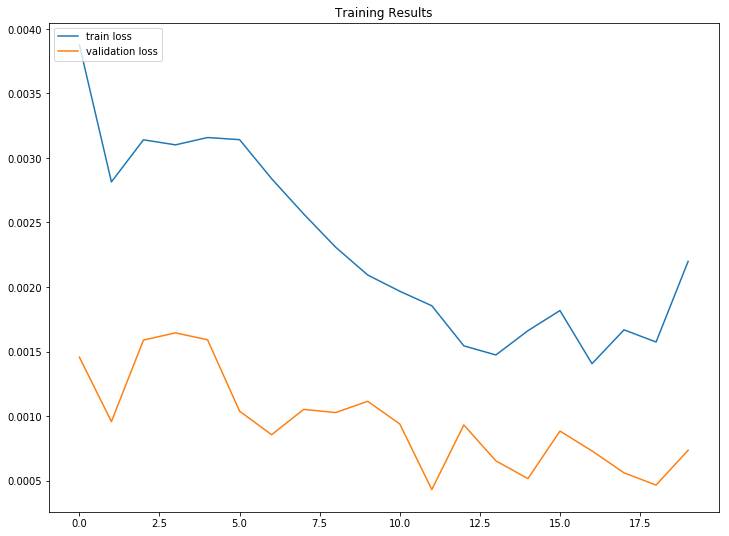

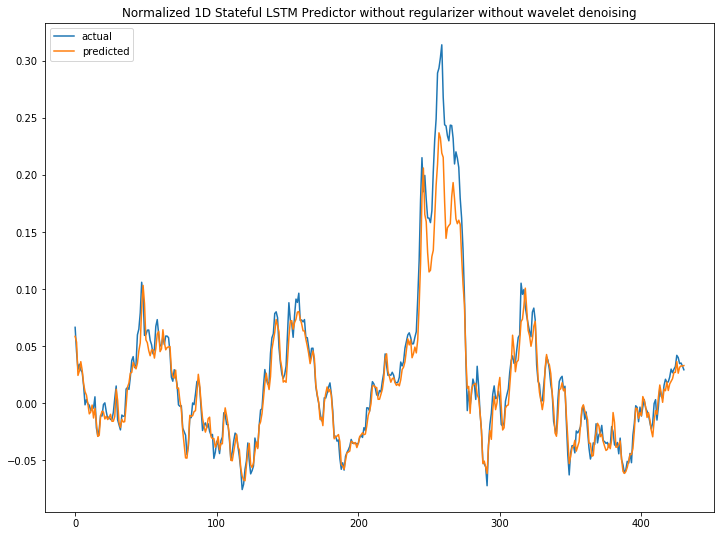

> Prediction vs Actual


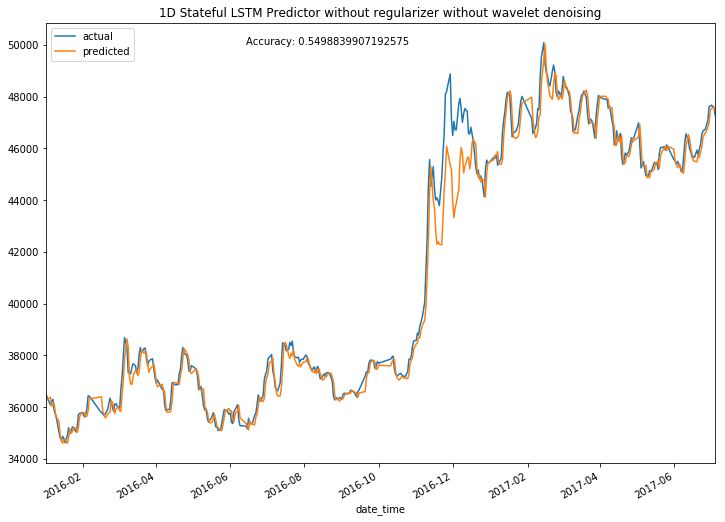

In [5]:
look_back = 32
model, history, actual, predicted = WaveletPredictor(epochs=20, LSTM_Stateful=True, network_structure=[1, look_back, 128, 1], look_back=look_back)

Test:  3955
Train: 20408
> Using regularizer: None
> Compilation Time :  0.029407978057861328
> Model Summary: 
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_3 (LSTM)                (1, 32, 32)               4352      
_________________________________________________________________
lstm_4 (LSTM)                (1, 128)                  82432     
_________________________________________________________________
dense_2 (Dense)              (1, 1)                    129       
_________________________________________________________________
activation_2 (Activation)    (1, 1)                    0         
Total params: 86,913
Trainable params: 86,913
Non-trainable params: 0
_________________________________________________________________
None
Train on 19387 samples, validate on 1021 samples
Epoch 1/20
19387/19387 [==============================] - 1797s - loss: 3.9713e-04 - val_loss: 1.4558e-0

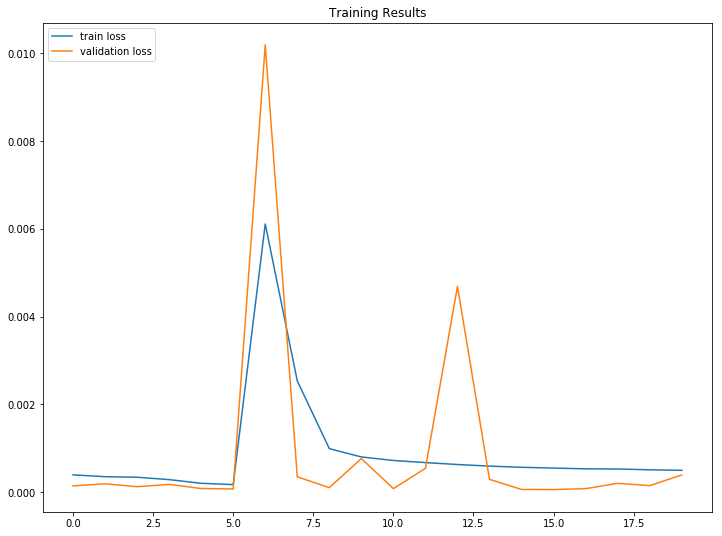

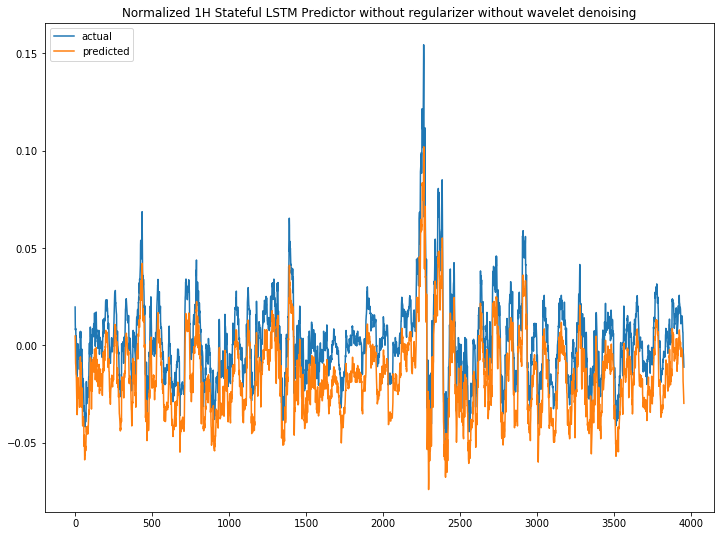

> Prediction vs Actual


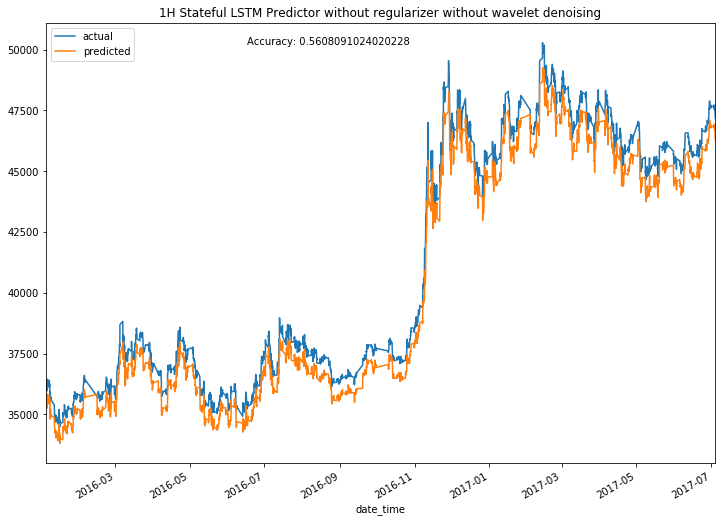

In [6]:
# Stateful LSTM 1 hour
look_back = 32
model, history, actual, predicted = WaveletPredictor(
    time_interval="1H",
    epochs=20, 
    LSTM_Stateful=True, 
    network_structure=[1, look_back, 128, 1], 
    look_back=look_back)

Test:  18315
Train: 90148
> Using regularizer: None
> Compilation Time :  0.023168087005615234
> Model Summary: 
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_7 (LSTM)                (1, 32, 32)               4352      
_________________________________________________________________
lstm_8 (LSTM)                (1, 128)                  82432     
_________________________________________________________________
dense_4 (Dense)              (1, 1)                    129       
_________________________________________________________________
activation_4 (Activation)    (1, 1)                    0         
Total params: 86,913
Trainable params: 86,913
Non-trainable params: 0
_________________________________________________________________
None
Train on 85640 samples, validate on 4508 samples
Epoch 1/5
85640/85640 [==============================] - 9288s - loss: 7.5125e-05 - val_loss: 2.7206e-0

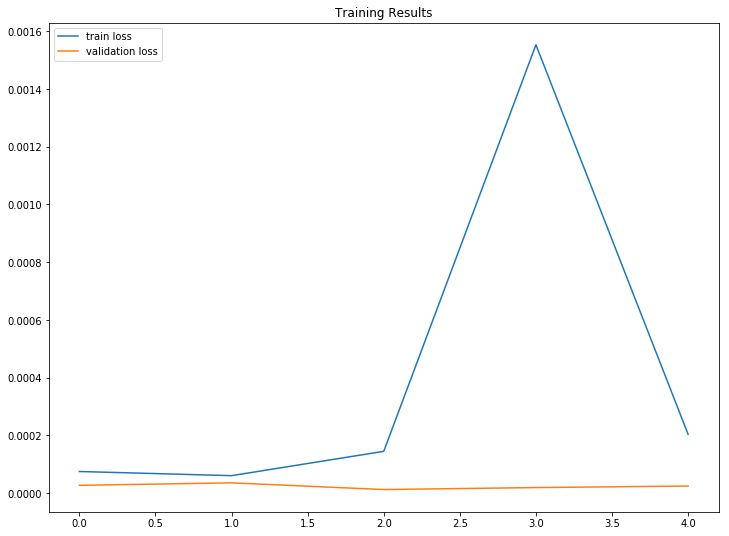

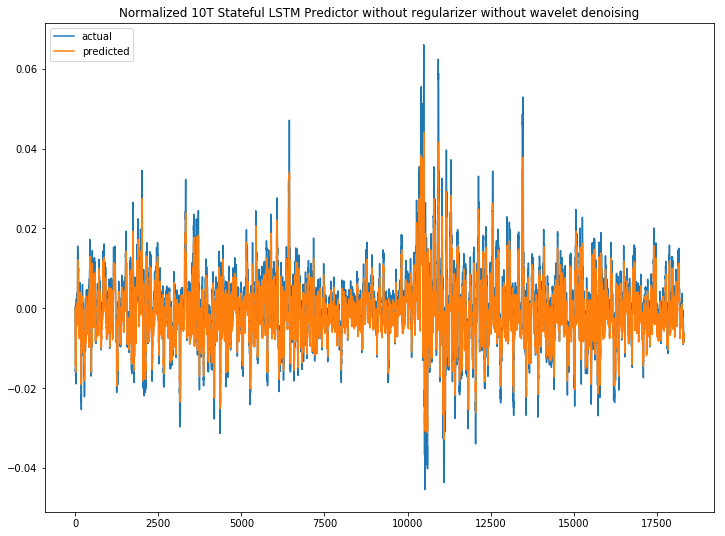

> Prediction vs Actual


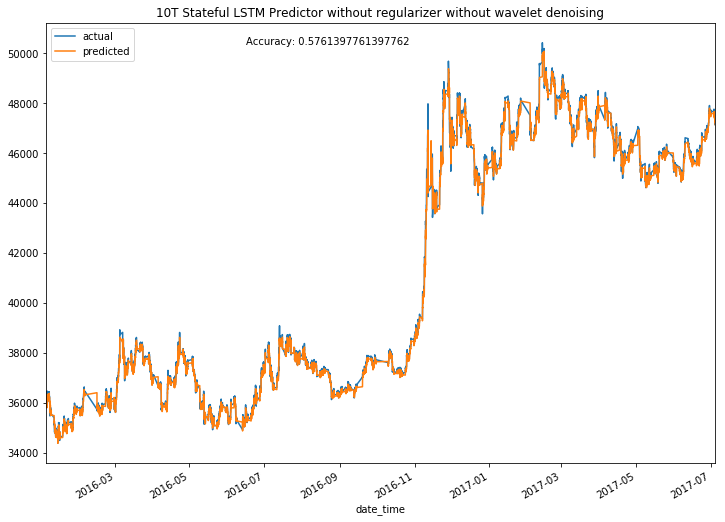

In [8]:
# Stateful LSTM
look_back = 32
model, history, actual, predicted = WaveletPredictor(
    time_interval="10T",
    epochs=5, 
    LSTM_Stateful=True, 
    network_structure=[1, look_back, 128, 1], 
    look_back=look_back)

##### 1D Stateless LSTM with regularizer 

Test:  431
Train: 3065
> Using regularizer: l1
> Compilation Time :  0.02608513832092285
> Model Summary: 
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_7 (LSTM)                (None, 32, 32)            4352      
_________________________________________________________________
lstm_8 (LSTM)                (None, 128)               82432     
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 129       
_________________________________________________________________
activation_4 (Activation)    (None, 1)                 0         
Total params: 86,913
Trainable params: 86,913
Non-trainable params: 0
_________________________________________________________________
None
Train on 2911 samples, validate on 154 samples
Epoch 1/20
2911/2911 [==============================] - 12s - loss: 11.2631 - val_loss: 2.6186
Epoch 2/20
2911/

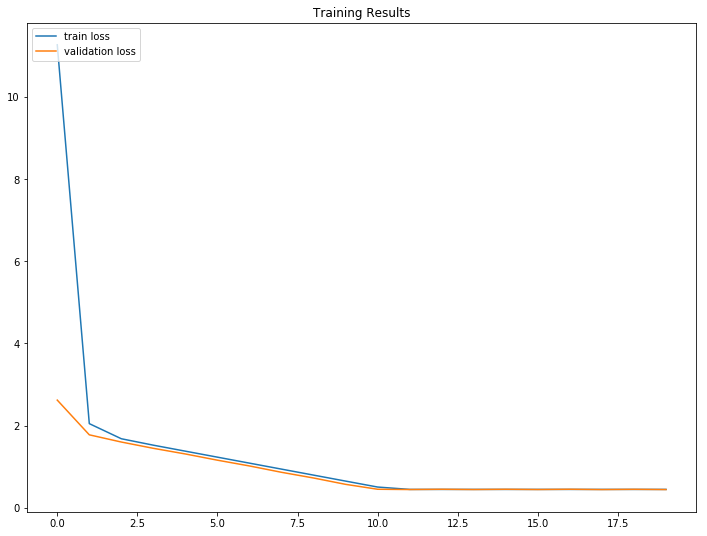

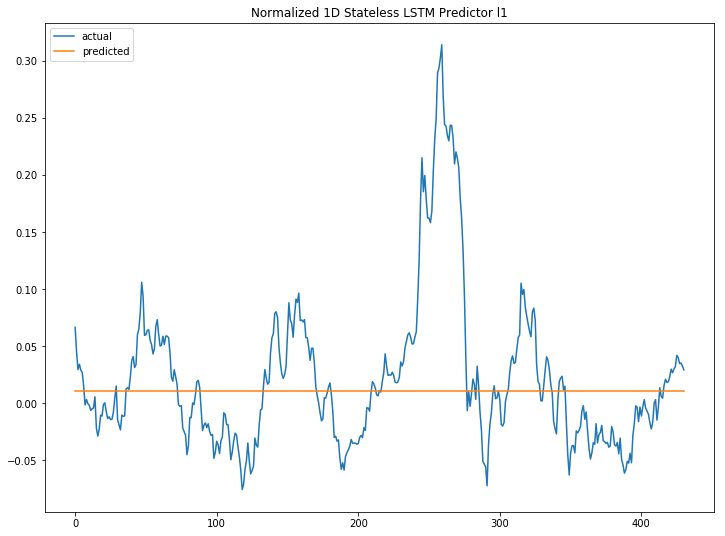

> Prediction vs Actual


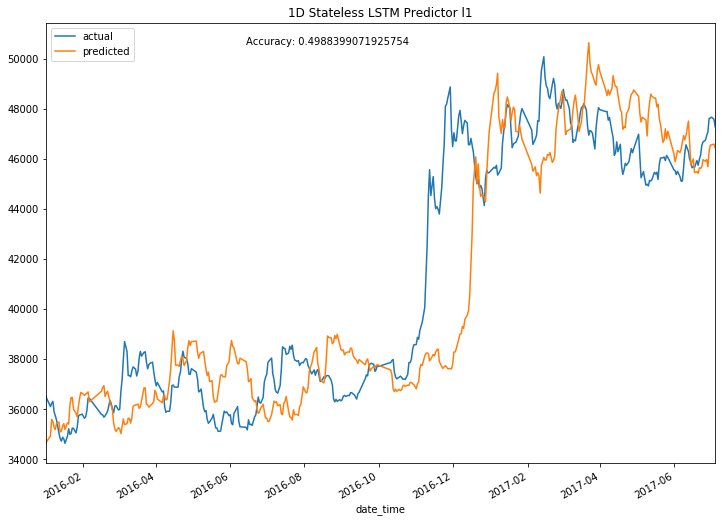

In [11]:
look_back = 32
model, history, actual, predicted = WaveletPredictor(epochs=20, regularizer='l1', network_structure=[1, look_back, 128, 1], look_back=look_back)

##### Stateless LSTM with shorter look_back

Test:  431
Train: 3093
> Using regularizer: None
> Compilation Time :  0.021984100341796875
> Model Summary: 
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_9 (LSTM)                (None, 4, 4)              96        
_________________________________________________________________
lstm_10 (LSTM)               (None, 128)               68096     
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 129       
_________________________________________________________________
activation_5 (Activation)    (None, 1)                 0         
Total params: 68,321
Trainable params: 68,321
Non-trainable params: 0
_________________________________________________________________
None
Train on 2938 samples, validate on 155 samples
Epoch 1/20
2938/2938 [==============================] - 4s - loss: 9.1093e-04 - val_loss: 5.2015e-04
Epoch 2

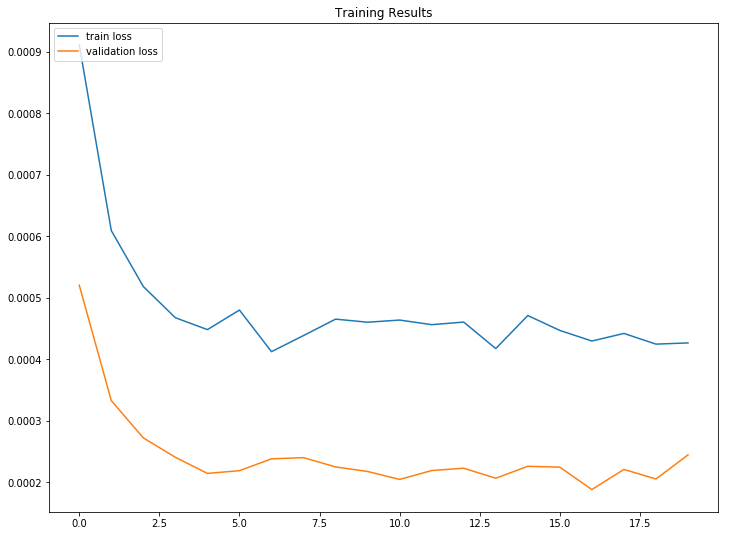

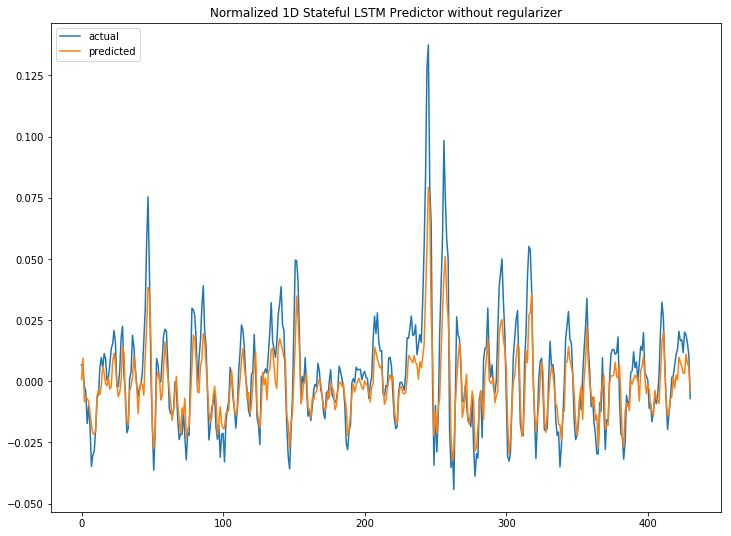

> Prediction vs Actual


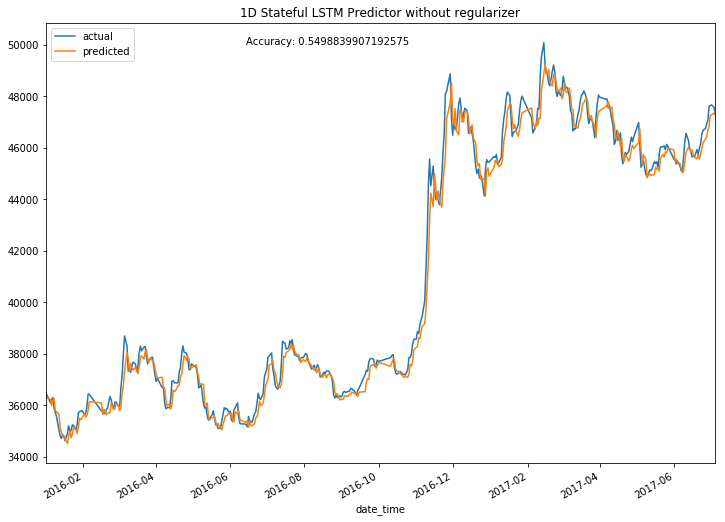

In [12]:
look_back = 4
model, history, actual, predicted = WaveletPredictor(epochs=20, LSTM_Stateful=False, network_structure=[1, look_back, 128, 1], look_back=look_back)

##### Stateless LSTM with longer look_back

Test:  431
Train: 2997
> Using regularizer: None
> Compilation Time :  0.021847009658813477
> Model Summary: 
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_11 (LSTM)               (None, 100, 100)          40800     
_________________________________________________________________
lstm_12 (LSTM)               (None, 128)               117248    
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 129       
_________________________________________________________________
activation_6 (Activation)    (None, 1)                 0         
Total params: 158,177
Trainable params: 158,177
Non-trainable params: 0
_________________________________________________________________
None
Train on 2847 samples, validate on 150 samples
Epoch 1/20
2847/2847 [==============================] - 36s - loss: 0.0131 - val_loss: 0.0051
Epoch 2/20
2

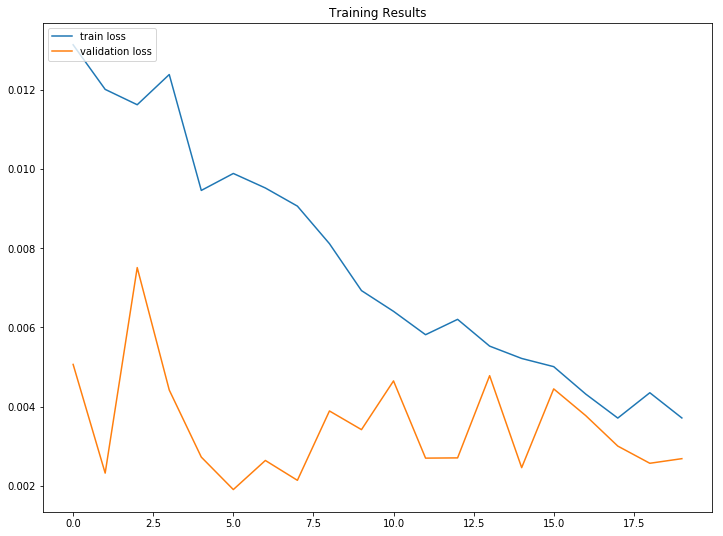

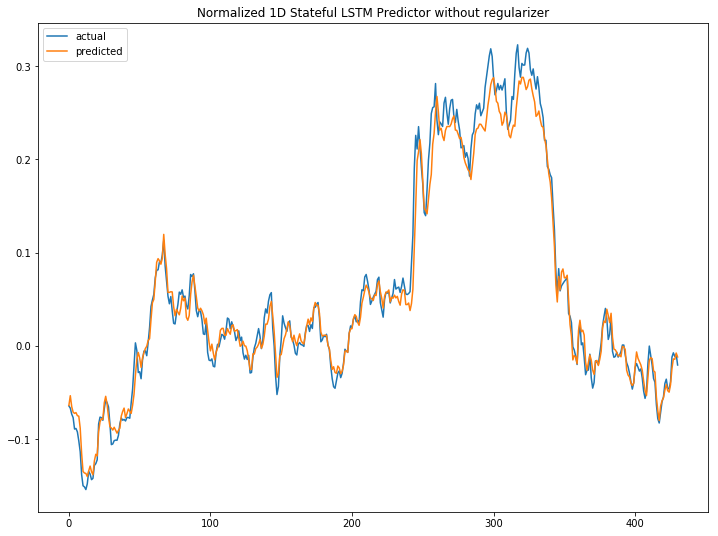

> Prediction vs Actual


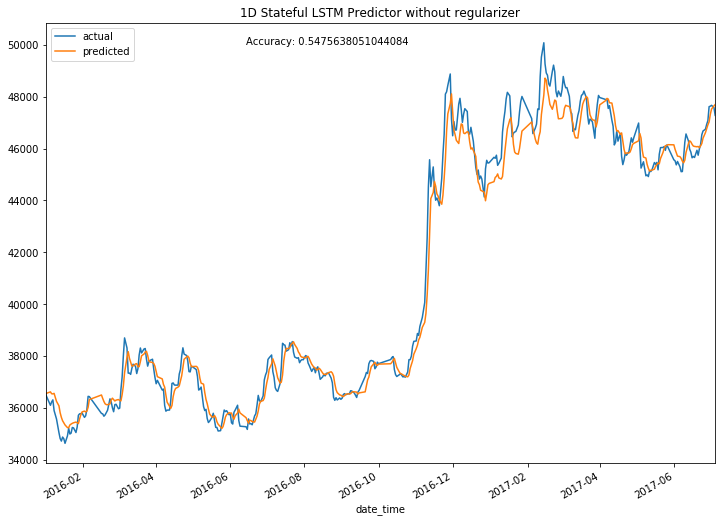

In [13]:
look_back = 100
model, history, actual, predicted = WaveletPredictor(epochs=20, LSTM_Stateful=False, network_structure=[1, look_back, 128, 1], look_back=look_back)

#### Time Interval - 1 hour

In [ ]:
look_back = 32
model, history, actual, predicted = WaveletPredictor(
    time_interval="1H", 
    epochs=40, 
    network_structure=[1, look_back, 128, 1], 
    look_back=look_back,
    batch_size=128
)

Test:  3955
Train: 20408
> Using regularizer: None
> Compilation Time :  0.020750999450683594
> Model Summary: 
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_13 (LSTM)               (None, 32, 32)            4352      
_________________________________________________________________
lstm_14 (LSTM)               (None, 128)               82432     
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 129       
_________________________________________________________________
activation_7 (Activation)    (None, 1)                 0         
Total params: 86,913
Trainable params: 86,913
Non-trainable params: 0
_________________________________________________________________
None
Train on 19387 samples, validate on 1021 samples
Epoch 1/40
19387/19387 [==============================] - 77s - loss: 3.9190e-04 - val_loss: 1.5623e-04


### Time Interval - 10 minutes

In [ ]:
look_back = 32
model, history, actual, predicted = WaveletPredictor(
    time_interval="10T", 
    epochs=20, 
    network_structure=[1, look_back, 128, 1], 
    look_back=look_back,
    batch_size=512
)

### Wavelet Transofrmation Plot

In [18]:
X = get_X_data("1D")
X["HLC"] = (X.high + X.low + X.close) / 3

In [20]:
wavelet_X = WaveletTransform(X)

There are total of 3529 elements


In [48]:
plt.clf()
plt.title("Copper Price from Shanghai Future Exchange")
plt.plot(X.HLC["2012":"2015"])
plt.plot(wavelet_X["2012":"2015"])
plt.legend(["Actual", "Wavelet Denoised"], loc='upper right')

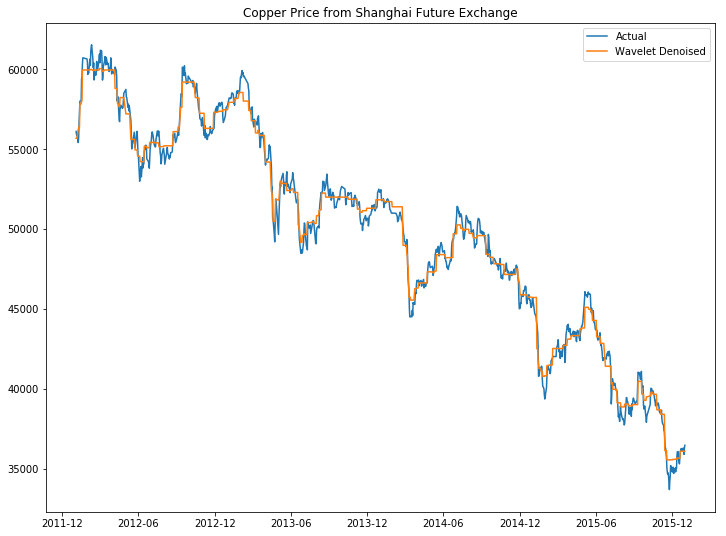

In [49]:
plt.show()

### Wavelet Predictor

There are total of 3529 elements
Test:  431
Train: 3065
> Using regularizer: None
> Compilation Time :  0.022311925888061523
> Model Summary: 
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_5 (LSTM)                (None, 32, 32)            4352      
_________________________________________________________________
lstm_6 (LSTM)                (None, 128)               82432     
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 129       
_________________________________________________________________
activation_3 (Activation)    (None, 1)                 0         
Total params: 86,913
Trainable params: 86,913
Non-trainable params: 0
_________________________________________________________________
None
Train on 2911 samples, validate on 154 samples
Epoch 1/20
2911/2911 [==============================] - 12s - loss: 0.0045 

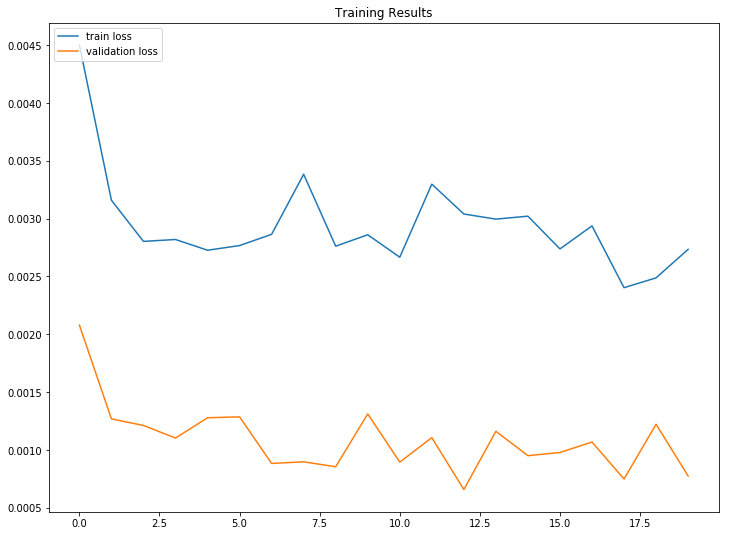

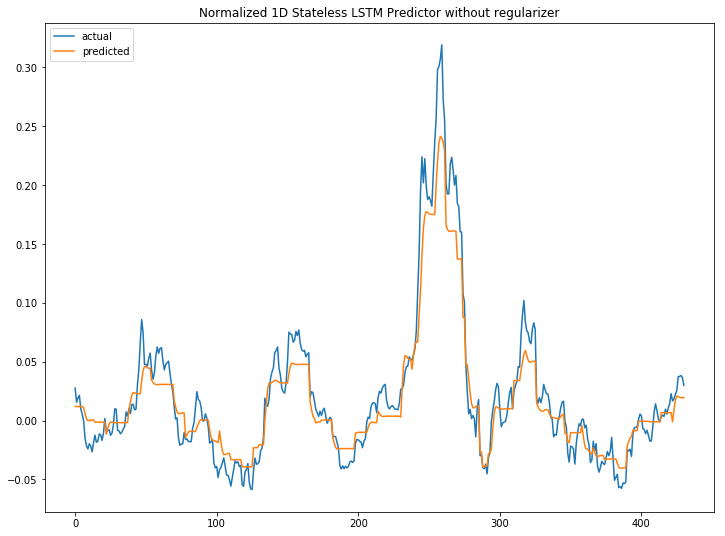

> Prediction vs Actual


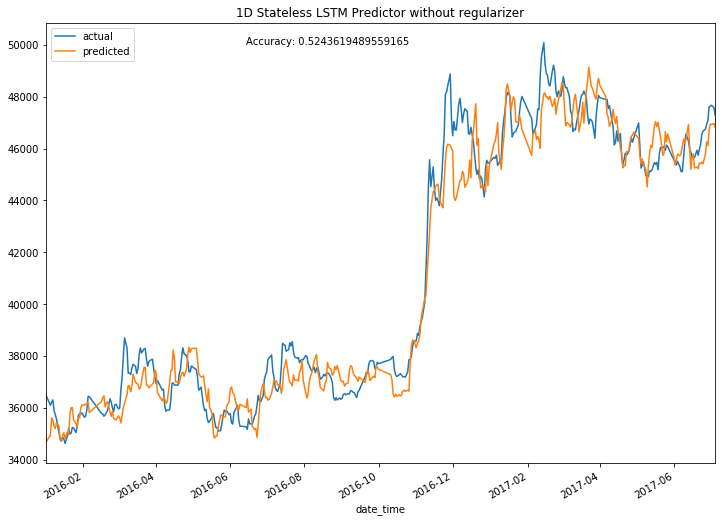

In [15]:
look_back = 32
model, history, actual, predicted = WaveletPredictor(
    wavelet_denoising=True,
    epochs=20, 
    network_structure=[1, look_back, 128, 1],
    look_back=look_back)